# cuDatashader vs Datashader comparison for simple points plotting

First, load the NYC Yellow Taxi dataset from January 2015 available here: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page :

In [8]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import cudf

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Choose GPU

pdf = pd.read_csv('data/nyc_taxi.csv', usecols=['dropoff_latitude','dropoff_longitude', 'passenger_count']) # Load into Pandas DF and select rows
pdf['passenger_count'] = pdf['passenger_count'].astype(np.float64) # Convert aggregation column
pdf.tail()

,passenger_count,dropoff_longitude,dropoff_latitude
12748981,2.0,-73.953735,40.775162
12748982,2.0,-73.974976,40.720013
12748983,1.0,-73.969101,40.787800
12748984,1.0,-73.981819,40.737652
12748985,1.0,-73.968643,40.760777


Then transform datapoints from GPS coordinates (longitudes, latitudes) to actually plottable 2D points :

In [9]:
from pyproj import Proj, transform

inProj = Proj(init='epsg:4326') # Latitude and longitudes
outProj = Proj(init='epsg:3857') # 2D projected points

x, y = transform(inProj, outProj, pdf['dropoff_longitude'].values, pdf['dropoff_latitude'].values) # Apply transformation

pdf['dropoff_x'] = x
pdf['dropoff_y'] = y

pdf.drop(['dropoff_latitude', 'dropoff_longitude'], axis=1, inplace=True)
pdf = pdf[~pdf.isin([np.nan, np.inf, -np.inf]).any(1)]

pdf = pdf[(pdf.dropoff_x > -8239910.23) & (pdf.dropoff_x < -8229529.24) & (pdf.dropoff_y > 4968481.34) & (pdf.dropoff_y < 4983152.92)] # Filter over Manhattan
#pdf = pdf.sample(frac=0.1) # Sample a fraction of the dataset

pdf.tail()

,passenger_count,dropoff_x,dropoff_y
12748981,2.0,-8.232492e+06,4.979234e+06
12748982,2.0,-8.234857e+06,4.971131e+06
12748983,1.0,-8.234203e+06,4.981092e+06
12748984,1.0,-8.235618e+06,4.973722e+06
12748985,1.0,-8.234152e+06,4.977120e+06


In [10]:
pdf.to_pickle('data/pdf.pkl') # Backup the dataset (prevent users from waiting above computations)

If you launched above computations once, you can start from there for now on

In [11]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import cudf

import time

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Choose GPU

pdf = pd.read_pickle('data/pdf.pkl') # Load backup
gdf = cudf.from_pandas(pdf) # Convert to cuDF DataFrame

In [12]:
print("Dataframe has {:,} rows".format(pdf.shape[0]))

Dataframe has 11,075,631 rows


## Render image with regular Datashader

583 ms


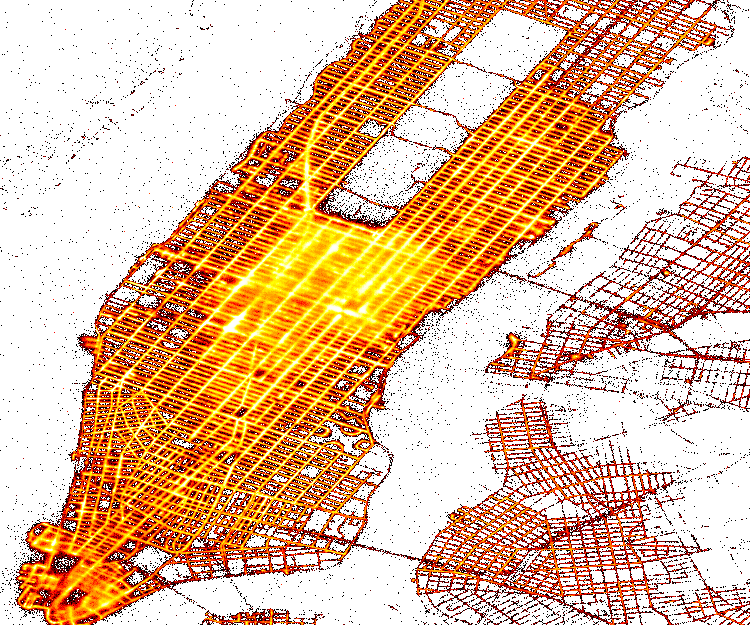

In [13]:
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import Hot

t0 = time.time() # Save start time
cvs = ds.Canvas(plot_width=750, plot_height=625, x_range=(-8239910.23,-8229529.24), y_range=(4968481.34,4983152.92)) # Create canvas
agg = cvs.points(pdf, 'dropoff_x', 'dropoff_y', ds.count('passenger_count')) # Perform aggregation
img = tf.shade(agg, cmap=Hot, how='eq_hist') # Produce image from aggregation
ds_time = time.time()-t0 # Compute elapsed time
print("{} ms".format(round(ds_time * 1000))) # Display elapsed time

img # Display image

## Render image with GPU accelerated cuDatashader (exact same usage/syntax)

12 ms


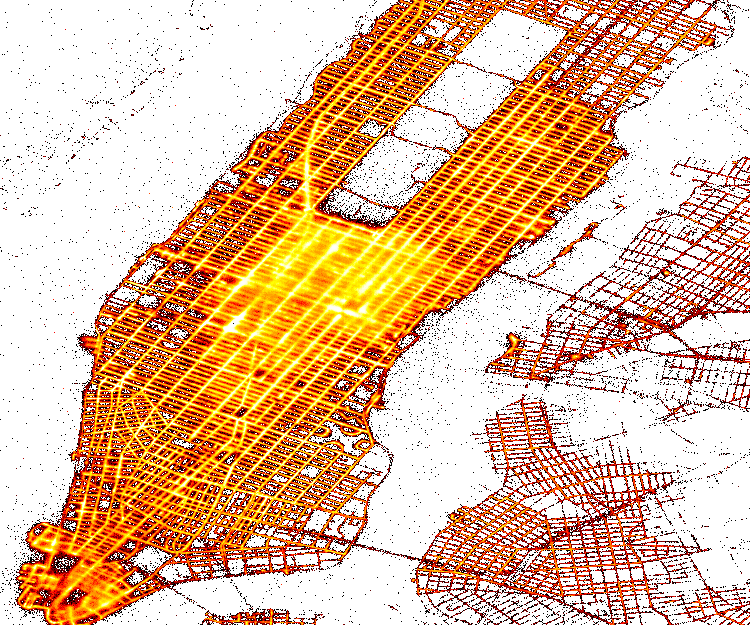

In [15]:
# Overloading Datashader functions
import cudatashader as ds
from cudatashader import transfer_functions as tf
from cudatashader.colors import Hot

t0 = time.time() # Save start time
cvs = ds.Canvas(plot_width=750, plot_height=625, x_range=(-8239910.23,-8229529.24), y_range=(4968481.34,4983152.92)) # Create canvas
agg = cvs.points(gdf, 'dropoff_x', 'dropoff_y', ds.count('passenger_count')) # Perform aggregation
img = tf.shade(agg, cmap=Hot, how='eq_hist') # Produce image from aggregation
cuviz_time = time.time()-t0 # Compute elapsed time
print("{} ms".format(round(cuviz_time * 1000))) # Display elapsed time

img # Display image

In [16]:
print('GPU speedup: {:.2f}'.format(ds_time/cuviz_time))

GPU speedup: 49.57
